In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import json
from tqdm import tqdm
from datetime import date
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load "soccer" Data

In [5]:
# Data from "soccer" database
con = sqlite3.connect('../input/soccer/database.sqlite')
players = pd.read_sql_query("SELECT * FROM Player JOIN Player_Attributes ON Player.id = Player_Attributes.id", con)

# Add an age column based on their birthday
players['birthday'] = pd.to_datetime(players['birthday'])
today = date.today()
players['age'] = today.year - players['birthday'].dt.year
# Adjust for leap year birthday
players['is_leap'] = players['birthday'].dt.is_leap_year  # identify leap year birthdays
players['age'] -= np.where((players['is_leap']) & (today.month < players['birthday'].dt.month) | 
                      (today.month == players['birthday'].dt.month) & (today.day < players['birthday'].dt.day), 1, 0)
players.drop(columns='is_leap', inplace=True)  # remove temporary column
print(players.shape)
players.head(1)

(11060, 50)


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,id,player_fifa_api_id,player_api_id,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,1,218353,505942,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,31


# Load "top5leaguesplayers-statsandphys" Data

In [6]:
def load_data():
    league_data_dir = os.getcwd() + '/data/leaguedata'
    all_data = []
    for _, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if not filename.startswith("20"):
                continue
            league = "Premier League" if "PremierLeague" in filename else "La Liga" if "LaLiga" in filename else "Bundesliga" if "Bundesliga" in filename else "SerieA" if "SerieA" in filename else "Ligue1"
            year = 2017 if "2017" in filename else 2018 if "2018" in filename else 2019 if "2019" in filename else "2020"
            f = open(f'../input/top5legauesplayers-statsandphys/Football_Players/{filename}', 'r')
            for line in f:
                data = json.loads(line)
                merged_dict = {
                    'name': data['name'] if 'name' in data else None, 
                    'age': data['age'] if 'age' in data else None, 
                    'nationality': data['nationality'] if 'nationality' in data else None,
                    'height': data['height'] if 'height' in data else None,
                    'weight': data['weight'] if 'weight' in data else None,
                    'team': data['team'] if 'team' in data else None,
                    'position': data['position'] if 'position' in data else None,
                    'league': league,
                    'year': year
                }
                merged_dict.update(data['general_stats'] if 'general_stats' in data else {})
                merged_dict.update(data['offensive_stats'] if 'offensive_stats' in data else {})
                merged_dict.update(data['passing_stats'] if 'passing_stats' in data else {})
                merged_dict.update(data['defensive_stats'] if 'defensive_stats' in data else {})
                all_data.append(merged_dict)
    player_data = pd.DataFrame(all_data)
    # drop rows with NaN (375 out of 6267)
    player_data = player_data.dropna()
    return player_data

player_data = load_data()
print(player_data.shape)
player_data.head(1)

(5892, 36)


,name,age,nationality,height,weight,team,position,league,year,games,...,PPA,CrsPA,Prog,Tkl,TklW,Past,Press,Succ,Blocks,Int
0,Mario Mandzukic,32,Croatia,190.0,85.0,Juventus,FW,SerieA,2018,25.0,...,20.0,7.0,38.0,37.0,22.0,20.0,497.0,140.0,27.0,12.0


# Load "player-scores" Data - has info on goals/assists/time played

In [8]:
appearances_df = pd.read_csv('/kaggle/input/player-scores/appearances.csv')
players_df = pd.read_csv('/kaggle/input/player-scores/players.csv')

player_stats_df = appearances_df.groupby(['player_name'])[['goals', 'assists', 'minutes_played']].sum().join(
    appearances_df.groupby(['player_name'])[['minutes_played']].count().rename(columns={'minutes_played': 'num_games'}),
    rsuffix='_num_games'
)


# Name to position map (Attack Defender Midfield)
grouped_positions = players_df.groupby('name')['position'].apply(', '.join).reset_index()
players_stats_df = pd.merge(player_stats_df, grouped_positions, left_on='player_name', right_on='name')
print(players_stats_df.shape)
players_stats_df.head(1)

(18814, 6)


,goals,assists,minutes_played,num_games,name,position
0,1,0,421,6,A.J. Soares,Defender


# Merge "soccer" and "player-scores" datasets

In [9]:
merged_df = pd.merge(players, players_stats_df, left_on='player_name', right_on='name')
# merged_df.columns
merged_df['height'] = merged_df['height'] / 2
merged_df['weight'] = merged_df['weight'] / 2
merged_df.columns

Index(['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday',
       'height', 'weight', 'id', 'player_fifa_api_id', 'player_api_id', 'date',
       'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'age', 'goals', 'assists', 'minutes_played', 'num_games',
       'name', 'position'],
      dtype='object')

# Create success metric
Currently I've only done work on attackers

In [10]:
min_age = merged_df['age'].min()
max_age = merged_df['age'].max()
scaling_factor = 1 - (merged_df['age'] - min_age) / (max_age - min_age)

merged_df['success'] = 90 * (merged_df['goals'] + merged_df['assists']) / merged_df['minutes_played'] * scaling_factor


# merged_df['success'] = 90 * (merged_df['goals'] + merged_df['assists']) / merged_df['minutes_played']
attacker_df = merged_df[merged_df['position'].str.contains('Attack')]
defender_df = merged_df[merged_df['position'].str.contains('Defender')]
midfielder_df = merged_df[merged_df['position'].str.contains('Midfield')]

# Begin Analysis

/tmp/ipykernel_34/3686824415.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  analysis_df = analysis_df[~analysis_df.isin([np.nan, np.inf, -np.inf, 0]).any(1)]


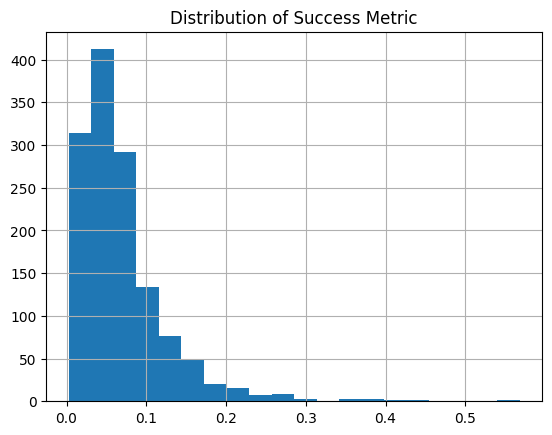

In [11]:
attributes = ['height', 'weight', 'age', 'jumping', 'stamina', 'strength', 'sprint_speed', 'acceleration']
success_attribute = 'success'
# success_attribute = 'overall_rating'
analysis_df = defender_df[attributes + [success_attribute]]
analysis_df = analysis_df[~analysis_df.isin([np.nan, np.inf, -np.inf, 0]).any(1)]
analysis_df[success_attribute].hist(bins=20)
plt.title("Distribution of Success Metric")
plt.show()

In [12]:
# Calculate z_score to determine where to cut off outliers
column_mean = np.mean(analysis_df['success'])
column_std = np.std(analysis_df['success'])
z_score = 2

upper_bound = column_mean + z_score * column_std
lower_bound = column_mean - z_score * column_std
print(lower_bound, upper_bound)

-0.04285817286561709 0.17959831280554778


0.0009447312790352338

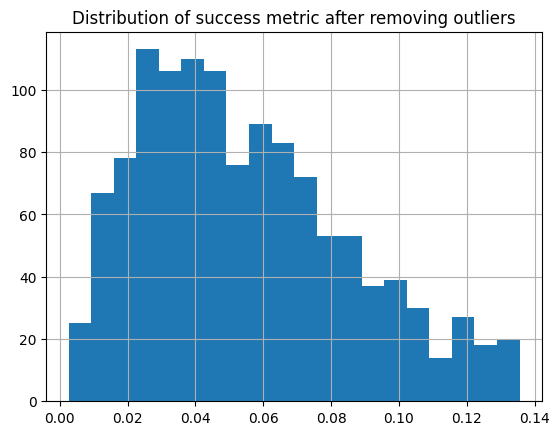

In [14]:
# Calculate z-scores for the column
z_scores = stats.zscore(analysis_df[success_attribute])

# Define a threshold for the z-score
threshold = 2

# Filter out rows where the z-score is greater than the threshold
analysis_df = analysis_df[(z_scores < threshold)]
analysis_df['success'].hist(bins=20)
plt.title("Distribution of success metric after removing outliers")
analysis_df['success'].var()

# Train Random Forest on Success Metric

In [15]:
# Calculate which subset of attributes has the best r-squared against success metric
import statsmodels.api as sm
from itertools import combinations

def get_subsets(lst, min_length, max_length):
    subsets = []
    for i in range(min_length, max_length + 1):
        for subset in combinations(lst, i):
            subsets.append(subset)
    return subsets

attribute_subsets = get_subsets(attributes, 1, 8)
r_squared = 0
best_attributes = []
for i, subset in tqdm(enumerate(attribute_subsets)):
    x = analysis_df[list(subset)]
    y = analysis_df[success_attribute]
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    if results.rsquared > r_squared:
        best_attributes = subset
        r_squared = results.rsquared
print(r_squared)
print(best_attributes)

255it [00:01, 179.61it/s]

0.16863465197827443
('height', 'weight', 'age', 'jumping', 'stamina', 'strength', 'sprint_speed', 'acceleration')


Train Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X = analysis_df[list(best_attributes)]
# X = analysis_df[['age', 'jumping', 'stamina', 'strength', 'sprint_speed', 'acceleration']]
Y = analysis_df[success_attribute]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model's performance on the testing data
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Test R^2 score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.0007422527946241484
Test R^2 score: 0.1866723401891135


Optimize Random Forest with Grid Search

In [34]:
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, 30, None]
#     'min_samples_split': [0, 2, 5, 10],
#     'min_samples_leaf': [0, 1, 2, 4]
}

# Create a RandomForestRegressor object
rf = RandomForestRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='r2')

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Use the best estimator to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the R^2 score on the test set
print("Test R^2 score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Best hyperparameters: {'max_depth': 5, 'n_estimators': 100}
Test R^2 score: 0.18966080805166763
Mean Squared Error: 0.0007395254822109188


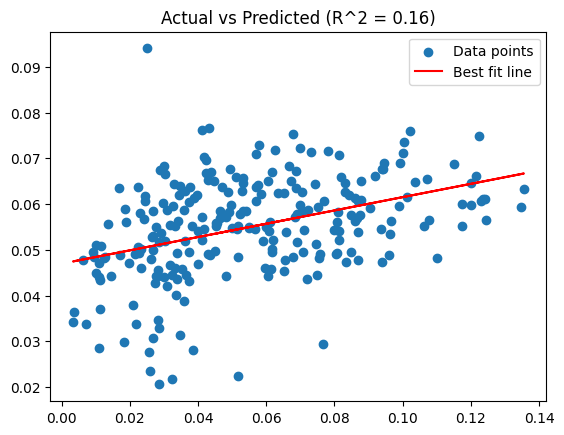

In [28]:
m, b = np.polyfit(y_test, y_pred, 1)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)

# Plot the data points and the best fit line
plt.scatter(y_test, y_pred)
plt.plot(y_test, m*y_test + b, color='red')

# Add title and legend
plt.title(f"Actual vs Predicted (R^2 = {r2:.2f})")
plt.legend(["Data points", "Best fit line"])
plt.show()